In [156]:
import sqlite3
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [157]:
df2 = pd.read_csv("cox-parsed.csv")
pd.set_option('display.max_columns', 52)
df2.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0
1,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,334,961,0
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0
4,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,63,64,1


In [158]:
workable_cols = ['id','sex','age','age_cat', 'race','juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out','c_charge_degree',
 'c_charge_desc',
'is_recid']
df_reduced = df2[workable_cols].copy()

In [159]:
c_jail_in = df_reduced['c_jail_in'].fillna(0).to_numpy()
c_jail_out = df_reduced['c_jail_out'].fillna(0).to_numpy()
def num_days(jail_in, jail_out):
    if jail_in == 0 or jail_out ==0:
        return 0
    else:
        in_time = [int(x) for x in jail_in]
        out_time = [int(x) for x in jail_out]
        year_diff = out_time[0]-in_time[0]
        month_diff = out_time[1]-in_time[1]
        day_diff = out_time[2]-in_time[2]+1
        total_diff = day_diff+30*month_diff+365*year_diff
        return total_diff
def process_dates(jail):
    out = []
    for x in range(len(jail)):
        curr = jail[x]
        if curr!=0:
            curr = curr.split(' ')[0].split('-')
        out.append(curr)
    return np.array(out)
c_jail_in = process_dates(c_jail_in)
c_jail_out = process_dates(c_jail_out)
num_days_inside = [num_days(x,y) for x,y in zip(c_jail_in,c_jail_out)]
df_reduced['num_days'] = num_days_inside
df_reduced.head()

,id,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,c_charge_desc,is_recid,num_days
0,1,Male,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,(F3),Aggravated Assault w/Firearm,0,2
1,1,Male,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,(F3),Aggravated Assault w/Firearm,0,2
2,3,Male,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,(F3),Felony Battery w/Prior Convict,1,10
3,4,Male,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,(F3),Possession of Cocaine,1,2
4,4,Male,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,(F3),Possession of Cocaine,1,2


In [160]:
df_reduced.drop('c_jail_in',axis=1,inplace=True)
df_reduced.drop('c_jail_out',axis=1,inplace=True)
df_reduced.drop('c_charge_desc',axis=1,inplace=True)
df_reduced.drop('days_b_screening_arrest',axis=1,inplace=True)
df_reduced = df_reduced.loc[(df_reduced['race'].isin(['African-American', 'Caucasian']))]
df_reduced['race'].replace('African-American',0, inplace=True)
df_reduced['race'].replace('Caucasian',1, inplace=True)
df_reduced['sex'].replace('Male',0, inplace=True)
df_reduced['sex'].replace('Female',1, inplace=True)
#df_reduced.drop('id',axis=1,inplace=True)

In [161]:
def age_cat_modifier(x):
    
    age_cat = {
        'Less than 25':0,
        '25 - 45':1,
        'Greater than 45':2,
    }
     
    for k,v in age_cat.items():
        if (k in x):
            return v
            
    return 0
df_reduced['age_cat'] = df_reduced['age_cat'].apply(age_cat_modifier)
df_reduced.head()

,id,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,num_days
2,3,0,34,1,0,0,3,0,0,0,(F3),1,10
3,4,0,24,0,0,0,4,0,1,4,(F3),1,2
4,4,0,24,0,0,0,4,0,1,4,(F3),1,2
5,5,0,23,0,0,0,8,1,0,1,(F3),0,0
8,8,0,41,1,1,0,6,0,0,14,(F3),1,7


In [162]:
charges_unique = []
for l in df_reduced['c_charge_degree'].dropna():
    charges_unique = charges_unique + [l]
charges_unique = np.array(charges_unique)
charges_unique, counts = np.unique(charges_unique, return_counts=True)
print(charges_unique, counts)

df_reduced = df_reduced.loc[(df_reduced['c_charge_degree'].isin(['(X)', '(F1)', '(F2)', '(F3)', '(F5)', '(F6)', '(F7)', '(M1)', '(M2)']))]

def crime_modifier(x):
    
    crime_cat = {
        '(X)':0,
        '(F1)':1, 
        '(F2)':2,
        '(F3)':3,
        '(F5)':4,
        '(F6)':5,
        '(F7)':6,
        '(M1)':7,
        '(M2)':8
    }
     
    for k,v in crime_cat.items():
        if (k in x):
            return v
            
    return 0

df_reduced['c_charge_degree'] = df_reduced['c_charge_degree'].apply(crime_modifier)
df_reduced.shape

['(CO3)' '(CT)' '(F1)' '(F2)' '(F3)' '(F5)' '(F6)' '(F7)' '(M1)' '(M2)'
 '(MO3)' '(NI0)' '(X)'] [   2    1  222 1044 6604   12   14  123 2466  878   97   10    1]


(11364, 13)

In [163]:
compas = df_reduced['decile_score'].to_numpy()
df_reduced.drop('decile_score',axis=1,inplace=True)

In [166]:
y=df_reduced['is_recid'].to_numpy()
df_reduced_X = df_reduced.drop('is_recid',axis=1)
s = df_reduced_X['race'].to_numpy()
df_reduced_X.drop('race', axis=1,inplace=True)
X = df_reduced_X.to_numpy()
X.shape,y.shape,s.shape

((11364, 10), (11364,), (11364,))

Importing and Pre-Processing Done. We have X, s and y. Now we move on to **training baseline models**

In [167]:
X_bs = np.hstack([X,s.reshape(s.shape[0],1)])
X_train, X_test, y_train, y_test = train_test_split(X_bs, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7954, 11), (3410, 11), (7954,), (3410,))

In [168]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.svm import LinearSVC as svm
#from sklearn.svm import SVC as svm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [169]:
def roc(true_labels, predicted,titles):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, predicted)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(titles)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return 1
def print_metrics(true_labels, predicted):
    def perf_measure(y_actual, y_hat):
        TP = 0.0
        FP = 0.0
        TN = 0.0
        FN = 0.0

        for i in range(len(y_hat)): 
            if y_actual[i]==y_hat[i]==1:
               TP += 1
            if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
               FP += 1
            if y_actual[i]==y_hat[i]==0:
               TN += 1
            if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
               FN += 1
        FPR = FP/(FP+TN)
        return FPR
    tn, fp, fn, tp = cm(true_labels, predicted).ravel()
    fpr = fp/(fp+tn)
    print("Accuracy:", accuracy_score(true_labels, predicted))
    print("Precision:", precision_score(true_labels, predicted))
    print("Recall:", recall_score(true_labels, predicted))
    print("False Positive Rate",fpr)# perf_measure(true_labels, predicted))
    print("F1 Score:", f1_score(true_labels, predicted))
    return 1

Logistic Regression is our baseline Model

Logistic Regression:
Accuracy: 0.6818181818181818
Precision: 0.6224188790560472
Recall: 0.18065068493150685
False Positive Rate 0.057091882247992866
F1 Score: 0.28002654280026545


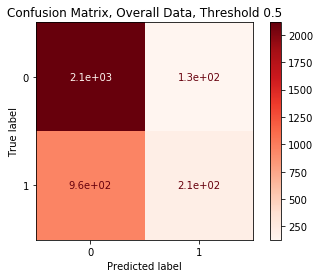

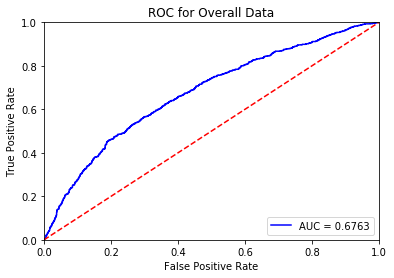

1

In [170]:
logisticRegr = LogisticRegression(C=1e7, max_iter=1000)
logisticRegr.fit(X_train, y_train)
LR_prediction = logisticRegr.predict(X_test)
print("Logistic Regression:")
print_metrics(y_test, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test, y_test,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Overall Data, Threshold 0.5")
plt.figure()
roc(y_test, logisticRegr.predict_proba(X_test)[:,1],"ROC for Overall Data")

As we can see, this gives this overall performance. But, we don't yet know how it performs on African Americans vs Caucasians separately. Also, we need to use a custom threshold, since COMPAS predicts any person with Medium/High Risk score to be likely to recidivate. Hence, we want to use a threshold that predicts positive for >0.35 (Medium).

Separate out African Americans and Caucasians for Comparative Analysis

In [171]:
X_test_aa = X_test[X_test[:,10]==0] #african-americans
y_test_aa = y_test[X_test[:,10]==0] 
X_test_c = X_test[X_test[:,10]==1] #caucasians 
y_test_c = y_test[X_test[:,10]==1]

Function to get metrics with custom threshold

In [172]:
def predict_thresh(threshold, prob):
    if prob>threshold:
        return 1
    else:
        return 0
func_final = np.vectorize(predict_thresh)

This gets baseline results for the combined dataset at a threshold of 0.35. We will call this setting as the new baseline

Accuracy: 0.6548387096774193
Precision: 0.49659348978046935
Recall: 0.5616438356164384
False Positive Rate 0.2966101694915254
F1 Score: 0.5271193250301326


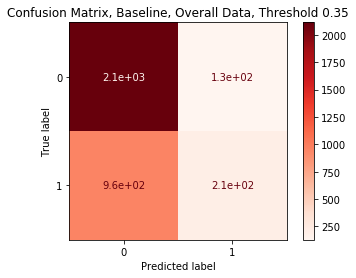

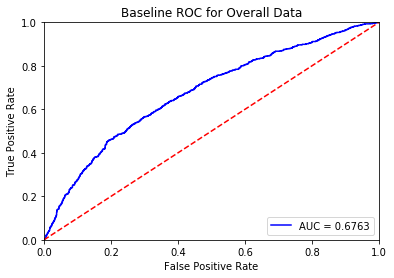

1

In [173]:
LR_probs = logisticRegr.predict_proba(X_test)[:,1]
thres = np.repeat(0.35,LR_probs.shape)
LR_prediction = func_final(thres,LR_probs)
print_metrics(y_test, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test, y_test,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Baseline, Overall Data, Threshold 0.35")
plt.figure()
roc(y_test, logisticRegr.predict_proba(X_test)[:,1],"Baseline ROC for Overall Data")

This gives baseline results for African Americans

Logistic Regression: Baseline, African Americans
Accuracy: 0.6194430874450415
Precision: 0.49096098953377737
Recall: 0.6789473684210526
False Positive Rate 0.4156954156954157
F1 Score: 0.5698509110988405


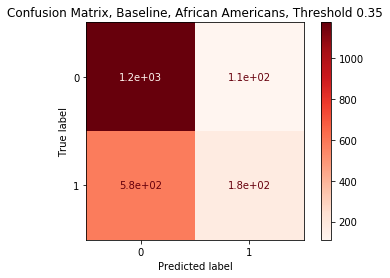

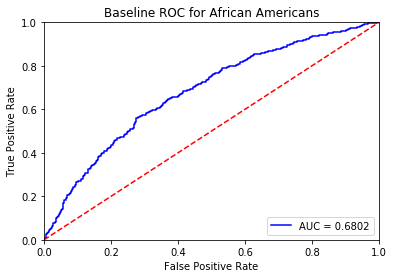

1

In [174]:
LR_probs = logisticRegr.predict_proba(X_test_aa)[:,1]
thres = np.repeat(0.35,LR_probs.shape)
LR_prediction = func_final(thres,LR_probs)
print("Logistic Regression: Baseline, African Americans")
print_metrics(y_test_aa, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test_aa, y_test_aa,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Baseline, African Americans, Threshold 0.35")
plt.figure()
roc(y_test_aa, logisticRegr.predict_proba(X_test_aa)[:,1],"Baseline ROC for African Americans")

This gives baseline results for Caucasians

Logistic Regression: Baseline, Caucasians
Accuracy: 0.7079970652971387
Precision: 0.5185185185185185
Recall: 0.3431372549019608
False Positive Rate 0.13612565445026178
F1 Score: 0.41297935103244837


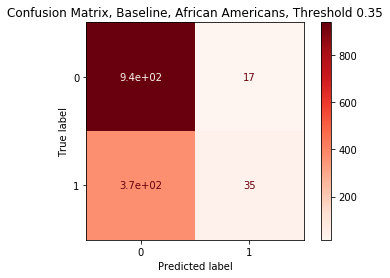

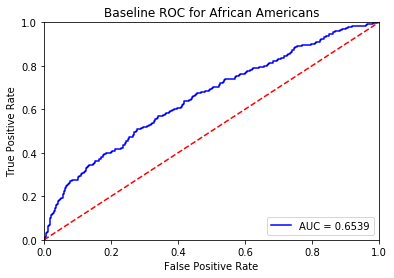

1

In [175]:
LR_probs = logisticRegr.predict_proba(X_test_c)[:,1]
thres = np.repeat(0.35,LR_probs.shape)
LR_prediction = func_final(thres,LR_probs)
print("Logistic Regression: Baseline, Caucasians")
print_metrics(y_test_c, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test_c, y_test_c,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Baseline, African Americans, Threshold 0.35")
plt.figure()
roc(y_test_c, logisticRegr.predict_proba(X_test_c)[:,1],"Baseline ROC for African Americans")

We also see what the results for the compas predictions were. They give a decile score which we binarize to draw comparisons

In [176]:
compas.shape, y.shape

((11364,), (11364,))

In [190]:
thres = np.repeat(3,compas.shape)
LR_prediction = func_final(thres,compas)
unique, counts = np.unique(LR_prediction, return_counts=True)
print_metrics(y, LR_prediction)

Accuracy: 0.5533262935586061
Precision: 0.4086586231369766
Recall: 0.7598310899973608
False Positive Rate 0.54996699669967
F1 Score: 0.5314749861546982


1

In [196]:
compas_x = np.hstack([X,s.reshape(-1,1)])
y_aa = y[compas_x[:,10]==0]
y_c = y[compas_x[:,10]==1]
compas_aa = compas[compas_x[:,10]==0]
compas_c = compas[compas_x[:,10]==1]

In [194]:
thres = np.repeat(3,compas_aa.shape)
LR_prediction = func_final(thres,compas_aa)
print_metrics(y_aa, LR_prediction)

Accuracy: 0.5220199647680563
Precision: 0.42422360248447205
Recall: 0.8118066561014263
False Positive Rate 0.648554104477612
F1 Score: 0.5572477563230894


1

In [195]:
thres = np.repeat(3,compas_c.shape)
LR_prediction = func_final(thres,compas_c)
print_metrics(y_c, LR_prediction)

Accuracy: 0.6001757469244289
Precision: 0.3747178329571106
Recall: 0.6561264822134387
False Positive Rate 0.42135686035898995
F1 Score: 0.47701149425287354


1

As we can see, there is a big difference in Equalized Odds values. Hence we try two methods: 1. the naive unawareness method and 2. The variational fair autoencoder method

1. **Unwareness**

In [179]:
X_train_unaware = np.delete(X_train,10, axis=1)
X_test_unaware = np.delete(X_test, 10, axis=1)
print(X_test_unaware.shape, X_train_unaware.shape)

(3410, 10) (7954, 10)


In [180]:
X_test_unaware_aa = X_test_unaware[X_test[:,10]==0]
X_test_unaware_c = X_test_unaware[X_test[:,10]==1]

Logistic Regression, Unaware, Overall Data
Accuracy: 0.6592375366568914
Precision: 0.5023847376788553
Recall: 0.541095890410959
False Positive Rate 0.2792149866190901
F1 Score: 0.5210222588623249


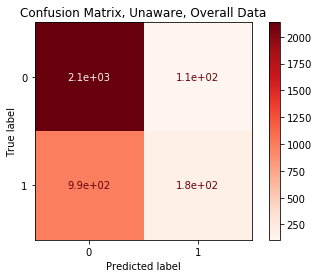

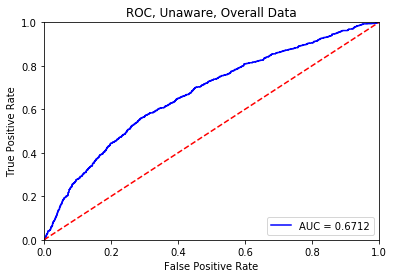

1

In [181]:
logisticRegr = LogisticRegression(C=1e7, max_iter=1000)
logisticRegr.fit(X_train_unaware, y_train)
#LR_prediction = logisticRegr.predict(X_test_unaware)
LR_probs = logisticRegr.predict_proba(X_test_unaware)[:,1]
thres = np.repeat(0.35,LR_probs.shape)
LR_prediction = func_final(thres,LR_probs)
print("Logistic Regression, Unaware, Overall Data")
print_metrics(y_test, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test_unaware, y_test,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Unaware, Overall Data")
plt.figure()
roc(y_test, logisticRegr.predict_proba(X_test_unaware)[:,1],"ROC, Unaware, Overall Data")

Logistic Regression: Unaware, African Americans
Accuracy: 0.6316560820713238
Precision: 0.5032397408207343
Recall: 0.6131578947368421
False Positive Rate 0.35742035742035744
F1 Score: 0.5527876631079478


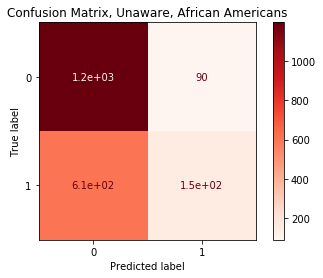

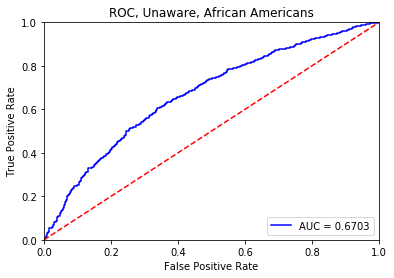

1

In [182]:
LR_probs = logisticRegr.predict_proba(X_test_unaware_aa)[:,1]
thres = np.repeat(0.35,LR_probs.shape)
LR_prediction = func_final(thres,LR_probs)
print("Logistic Regression: Unaware, African Americans")
print_metrics(y_test_aa, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test_unaware_aa, y_test_aa,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Unaware, African Americans")
plt.figure()
roc(y_test_aa, logisticRegr.predict_proba(X_test_unaware_aa)[:,1],"ROC, Unaware, African Americans")

Logistic Regression: Unaware, Caucasians
Accuracy: 0.7006603081438004
Precision: 0.5
Recall: 0.4068627450980392
False Positive Rate 0.17382198952879582
F1 Score: 0.4486486486486487


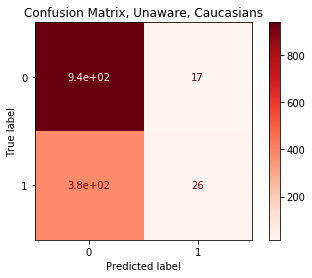

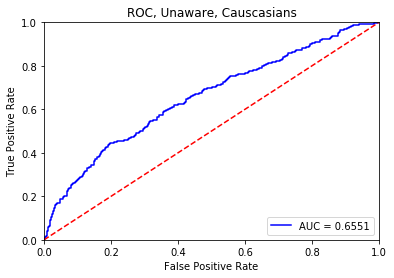

1

In [183]:
LR_probs = logisticRegr.predict_proba(X_test_unaware_c)[:,1]
thres = np.repeat(0.35,LR_probs.shape)
LR_prediction = func_final(thres,LR_probs)
print("Logistic Regression: Unaware, Caucasians")
print_metrics(y_test_c, LR_prediction)
confusion_matrix = plot_confusion_matrix(logisticRegr, X_test_unaware_c, y_test_c,cmap=plt.cm.Reds)
plt.title("Confusion Matrix, Unaware, Caucasians")
plt.figure()
roc(y_test_c, logisticRegr.predict_proba(X_test_unaware_c)[:,1],"ROC, Unaware, Causcasians")

Now we try the VFAE model

In [129]:
X_full = np.hstack([X,s.reshape(-1,1),y.reshape(-1,1)])
print(X_full.shape)
scalar = MinMaxScaler()
X_full = scalar.fit_transform(X_full)
X_train, X_test = train_test_split(X_full, test_size=0.30, random_state=42)
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_true = np.copy(X_test[:,:,X_test.shape[2]-1])
print(np.unique(y_true))
X_test[:,:,X_test.shape[2]-1] = -8*np.ones_like(y_true)
print(X_train.shape,X_test.shape, y_true.shape)

(11364, 12)
[0. 1.]
(7954, 1, 12) (3410, 1, 12) (3410, 1)


In [130]:
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
import keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate
import keras

In [131]:
dims = {
    'input': 9,
    'z1_enc_hidden': 20,
    'z1_enc' : 8,
    'z2_enc_hidden': 20,
    'z2_enc' : 8,
    'z1_dec_hidden': 20,
    'z1_dec': 8,
    'z2_dec_hidden': 20,
    'z2_dec': 10,
    'y_hidden': 20,
    'y': 1,
    'D': 100,
    'gamma':1,
    'beta':10,
    'alpha':0.1,
    'recon_rate':0.1,
    'lhx':1
       }

In [62]:
def vfae_model(inputs):
    #input is [X,s,y] 1,11
    
    def gather(args):
        a,b = args
        out = tf.gather(a,b,axis=2)
        return out
    def concat(args):
        a,b = args
        return tf.concat([a,b],axis=2)
    def sample(args):
        mu, log_sigma, eps = args
        exp = Lambda(lambda x:  tf.exp(x / 2))(log_sigma)
        return mu + exp * eps
    def KL(mu1,log_sigma_sq1,mu2=0.,log_sigma_sq2=0.):
        return 0.5*tf.reduce_sum(log_sigma_sq2-log_sigma_sq1-1+(tf.exp(log_sigma_sq1)+tf.pow(mu1-mu2,2))/tf.exp(log_sigma_sq2),axis=1)

    def psi(x):
        W = tf.Variable(tf.random.normal([dims['z1_enc'],dims['D']], 
                             stddev=tf.sqrt(0.5 / float(dims['z1_enc'])),
                             dtype=tf.float32))
        b = tf.Variable(tf.random.uniform([dims['D']],0,2*np.pi,dtype=tf.float32))
        return tf.pow(2./dims['D'],0.5)*tf.cos(tf.pow(2./dims['gamma'],0.5)*tf.matmul(x,W) + b)
    
    def fast_MMD(x1,x2):
        inner_difference = tf.reduce_mean(psi(x1),axis=0) - tf.reduce_mean(psi(x2),axis=0)
        return tf.tensordot(inner_difference,inner_difference,axes=1)

    def boolean_masking(t,s):
        return tf.boolean_mask(t,tf.tile(tf.cast(s,tf.bool),[1,tf.shape(t)[1]]))
    
    def reshaping_MMD(mmd,z):
        return tf.reshape(mmd,[tf.cast(tf.shape(mmd)[0]/tf.shape(z)[1],tf.int32),tf.shape(z)[1]])
    
    def total_MMD(z,s):
        z = tf.reshape(z, (tf.shape(z)[0],8))
        s = tf.reshape(s, (tf.shape(s)[0],1))
        a1 = boolean_masking(z,s)
        a2 = boolean_masking(z,1-s)
        b1 = reshaping_MMD(a1,z)
        b2 = reshaping_MMD(a2,z)
        mmd = fast_MMD(b1,b2)
        return mmd
        
    indices = Lambda(lambda x: tf.range(dims['input']))(inputs)
    x_net = Lambda(gather)([inputs,indices])
    indices2 = Lambda(lambda x: tf.constant(dims['input']))(inputs)
    s_net = Lambda(gather)([inputs, indices2])
    s_net = Lambda(lambda x: tf.expand_dims(x,axis=1))(s_net)
    indices3 = Lambda(lambda x: tf.constant(dims['input']+1))(inputs)
    y_net = Lambda(gather)([inputs, indices3])
    y_net = Lambda(lambda x: tf.expand_dims(x,axis=1))(y_net)
    
    tester = Lambda(lambda t: -8*tf.ones_like(y_net))(inputs)
    check = Lambda(lambda t: tf.cast(tf.keras.backend.equal(tester, y_net),dtype=tf.int32))(inputs)
    check2 = Lambda(lambda t: tf.cast(tf.reduce_mean(check)==tf.constant(1),dtype=tf.int32))(inputs)
    #c = tf.keras.backend.equal(a,b)
    #c_new = tf.cast(c, dtype=tf.int32)
    #d = tf.reduce_mean(c_new)==tf.constant(1)
    #if check2.output == 1:
     #   print("hell yeah")
    
    '''Encoder 1'''
    inputs_in = Lambda(concat)([x_net,s_net])
    h_q_z1 = Dense(dims['z1_enc_hidden'], activation='relu')(inputs_in)
    mu_z1 = Dense(dims['z1_enc'], activation='linear')(h_q_z1)
    log_sigma_z1 = Dense(dims['z1_enc'], activation='linear')(h_q_z1)
    
    '''sampling encoder 1'''
    eps1 = Lambda(lambda args: tf.random.normal(shape=(dims['z1_enc'],), mean=0., stddev=1.))(inputs)
    z_1_enc = Lambda(sample)([mu_z1, log_sigma_z1, eps1])
    
    '''y'''
    h_q_y_us = Dense(dims['y_hidden'], activation='relu')(z_1_enc)
    mu_us = Dense(dims['y'], activation='sigmoid')(h_q_y_us) #mu_y_us 
    log_sigma_us = Dense(dims['y'], activation='sigmoid')(h_q_y_us)
    
    '''sampling y'''
    eps6 = Lambda(lambda args: tf.random.normal(shape=(dims['y'],), mean=0., stddev=1.))(inputs)
    y_us = Lambda(sample)([mu_us, log_sigma_us, eps6])
    print(y_net.get_shape(),y_us.get_shape())
    
    '''
    if(mode=='test'):
        y_net = y_us
        print("I should be here")
    '''
        
    y_net = Lambda(lambda t: tf.cond(check2 == tf.constant(1), lambda: y_us, lambda: y_net))(inputs)
    print(y_net.get_shape())
    '''Encoder 2'''
    new_input = Lambda(concat)([z_1_enc,y_net])
    h_q_z2 = Dense(dims['z2_enc_hidden'], activation='relu')(new_input)
    mu_z2 = Dense(dims['z2_enc'], activation='linear')(h_q_z2)
    log_sigma_z2 = Dense(dims['z2_enc'], activation='linear')(h_q_z2)
    
    '''sampling encoder 2'''
    eps2 = Lambda(lambda args: tf.random.normal(shape=(dims['z2_enc'],), mean=0., stddev=1.))(inputs)
    z_2_enc = Lambda(sample)([mu_z2, log_sigma_z2,eps2])
    
    #print("not here")
    '''Decoder 1'''
    newer_input = Lambda(concat)([z_2_enc,y_net])
    h_q_z1_dec = Dense(dims['z1_dec_hidden'], activation='relu')(newer_input)
    mu_z1_dec = Dense(dims['z1_dec'], activation='linear')(h_q_z1_dec)
    log_sigma_z1_dec = Dense(dims['z1_dec'], activation='linear')(h_q_z1_dec)
    
    '''sampling posterior z1 or decoder 1'''
    eps3 = Lambda(lambda args: tf.random.normal(shape=(dims['z1_dec'],), mean=0., stddev=1.))(inputs)
    z_1_dec = Lambda(sample)([mu_z1_dec, log_sigma_z1_dec,eps3])
    
    '''Decoder 2'''
    final_input = Lambda(concat)([z_1_dec,s_net])
    h_q_z2_dec = Dense(dims['z2_dec_hidden'], activation='relu')(final_input)
    x_out = Dense(dims['z2_dec'], activation='softmax')(h_q_z2_dec) #mu_z2_dec 
    print(x_out.get_shape())

    output = Lambda(concat)([x_out,y_us])
    print(output.get_shape())
    
    #MMD_x1 = Lambda(boolean_masking)(z_1_enc, s_net)
    #MMD_x2 = Lambda(boolean_masking)(z_1_enc, 1-s_net)
    #MMD_x1 = Lambda(reshaping_mmd)(MMD_x1, z_1_enc)
    #MMD_x2 = Lambda(reshaping_mmd)(MMD_x2, z_1_enc)
    
    #MMD_x1 = tf.boolean_mask(z1_enc,tf.tile(tf.cast(s_net,tf.bool),[1,tf.shape(z1_enc)[1]]))
    #MMD_x2 = tf.boolean_mask(z1_enc,tf.tile(tf.cast(1-s_net,tf.bool),[1,tf.shape(z1_enc)[1]]))
    #MMD = fast_MMD(tf.reshape(MMD_x1,[tf.cast(tf.shape(MMD_x1)[0]/tf.shape(z1_enc)[1],tf.int32),tf.shape(z1_enc)[1]]),
                  # tf.reshape(MMD_x2,[tf.cast(tf.shape(MMD_x2)[0]/tf.shape(z1_enc)[1],tf.int32),tf.shape(z1_enc)[1]]),
                  #params)
    #MMD = Lambda(fast_MMD)(MMD_x1,MMD_x2)
    
    #print(z_1_enc.get_shape(), s_net.get_shape())
    #z_1_enc = Lambda(lambda t: tf.reshape(z_1_enc, (tf.shape(z_1_enc)[0],8)))(inputs)
    #s_net = Lambda(lambda t: tf.reshape(s_net, (tf.shape(s_net)[0],1)))(inputs)
    #print(z_1_enc.get_shape(), s_net.get_shape())
    #MMD_x1 = reshaping_MMD(boolean_masking(z_1_enc, s_net),z_1_enc)
    #MMD_x2 = reshaping_MMD(boolean_masking(z_1_enc, 1-s_net),z_1_enc)
    #MMD = fast_MMD(reshaping_MMD(boolean_masking(z_1_enc, s_net),z_1_enc), reshaping_MMD(boolean_masking(z_1_enc, 1-s_net),z_1_enc))
    
    MMD = total_MMD(z_1_enc, s_net)
    KL_z1 = KL(mu_z1,log_sigma_z1,mu_z1_dec,log_sigma_z1_dec)
    KL_z2 = KL(mu_z2,log_sigma_z2)
    
    return output, KL_z1, KL_z2, MMD
    

In [63]:
inputs = Input(shape=(1,dims['input']+2))

In [64]:
outputs, KL_z1, KL_z2, MMD = vfae_model(inputs)
tf.keras.backend.print_tensor(outputs[1])
vfae = Model(inputs,outputs)

(None, 1, 1) (None, 1, 1)
(None, 1, 1)
(None, 1, 10)
(None, 1, 11)


In [ ]:
#@tf.function
#def loss_big(KL_z1, KL_z2, MMD):
@tf.function
def vfae_loss(y_true, y_pred):
    #y_true and y_pred are the full things
        
    x_s = y_true[:,:,:-1]#,tf.range(dims['input']+1),axis=2) #this is x and s
    x_out =  y_pred[:,:,:-1] #tf.gather(y_pred,tf.range(dims['input']+1),axis=2) #this is xout
    tf.print(x_s.get_shape(),x_out.get_shape())
    LH_x = tf.reduce_sum(x_s * tf.math.log(1e-10+(x_out)) + (1 - x_s) * tf.math.log(1e-10+ (1 - x_out)),axis=1)
    #tf.print(LH_x)
        
    #y = tf.gather(y_true,dims['input']+1,axis=2) #this is y
    #y_us = tf.gather(y_pred,dims['input']+1,axis=2) #this is y_us
        
    #y = y_true[:,0,-1]
    #y_us = y_pred[:,0,-1]
    recon = dims['recon_rate']*tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_pred[:,:,-1], y_true[:,:,-1]))#, axis=1)
    #index = tf.range(tf.shape(y)[0])  
    #idx = tf.stack([index[:, tf.newaxis], tf.cast(y,tf.int32)], axis=-1)
    #LH_y = tf.reduce_sum(tf.math.log(1e-10+y_us))
    #LH_y = tf.reduce_sum(y * tf.math.log(1e-10+(y_us)) + (1 - y) * tf.math.log(1e-10+ (1 - y_us)))
    mmd = 10*MMD
    #tf.print(tf.reduce_mean(KL_z1),tf.reduce_mean(KL_z2),tf.reduce_mean(LH_x),recon)
    
    '''
        tf.print(LH_y.get_shape())
        tf.keras.backend.print_tensor(LH_y.get_shape())
        
    '''
        
    #LH_x = keras.losses.mean_squared_error(y_true[:,:,:-1], y_pred[:,:,:-1])
    #LH_y = keras.losses.mean_squared_error(y_true[:,:,-1], y_pred[:,:,-1])
    loss = -(-tf.reduce_mean(KL_z1)-tf.reduce_mean(KL_z2)+dims['lhx']*tf.reduce_mean(LH_x))#- dims['alpha']*tf.reduce_mean(LH_y)) #+tf.reduce_mean(LH_x)
    #bla = y_true-y_pred
    #mmd = dims['beta']*MMD
    return (loss+recon)

In [ ]:
vfae.compile(optimizer='adam', loss=vfae_loss)

In [ ]:
history = vfae.fit(X_train, X_train, validation_split=0.3,batch_size=50, epochs=10)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()